In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [30]:
import pandas as pd
import glob
import os

# Directory path
csv_dir = "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/aml_zero"

# Get all CSV files in the directory
csv_files = [
    f for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df['source_file'] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASSDQGVNEQFF,0.055556,0.024469,False,0.001359,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...
1,CASSPQTGDTDTQYF,0.037037,0.040908,False,0.001515,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...
2,CSAPGSGVMRSTDTQYF,0.027778,0.000042,False,0.000001,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...
3,CSASVW,0.027778,0.294831,False,0.008190,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...
4,CATSDRQGNTEAFF,0.027778,0.996675,True,0.027686,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...
...,...,...,...,...,...,...
13690,CASSRPALEQGNYGYTF,0.009091,0.984525,True,0.008950,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...
13691,CASRLIDSFSYEQYF,0.009091,0.963227,True,0.008757,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...
13692,CSARGGMSYEQYF,0.009091,0.695003,True,0.006318,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...
13693,CASSKGYLETQYF,0.009091,0.727591,True,0.006615,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...


In [31]:
import numpy as np

def fraction_to_percentile(
    x,
    weights=None,
    method="hazen",          # "weibull", "hazen", "blom", "bernard", "rank"
    open_interval=False,     # map from [0,1] to (eps,1-eps) if True
    eps=1e-9,
    nan_policy="omit"        # "omit", "propagate", "raise"
):
    """
    Percentile transform via empirical CDF with optional weights and plotting positions.

    Parameters
    ----------
    x : array-like of shape (n,)
        Raw values.
    weights : array-like of shape (n,), optional
        Nonnegative weights. If None, all weights are 1.
    method : {"weibull","hazen","blom","bernard","rank"}
        Plotting position for unweighted case:
          weibull:  p_i = i / (n+1)
          hazen:    p_i = (i - 0.5) / n
          blom:     p_i = (i - 0.375) / (n + 0.25)
          bernard:  p_i = (i - 3/8) / (n + 1/4)
          rank:     p_i = (i - 1) / (n - 1)  if n>1 else 0.5
        For the weighted case we use midpoint-of-jump ECDF:
          p(v_j) = (CW_{j-1} + 0.5 w_j) / CW_total
        which is method-free and statistically standard.
    open_interval : bool
        If True, map 0 to eps and 1 to 1-eps.
    eps : float
        Small margin used if open_interval is True.
    nan_policy : {"omit","propagate","raise"}
        NaN handling.

    Returns
    -------
    p : ndarray of shape (n,)
        Percentiles in [0,1] or (eps,1-eps) if open_interval=True.
    """
    x = np.asarray(x, dtype=float)
    n = x.size

    if n == 0:
        return x

    # NaN handling
    has_nan = np.isnan(x).any()
    if has_nan:
        if nan_policy == "raise":
            raise ValueError("NaNs present with nan_policy='raise'.")
        if nan_policy == "propagate":
            return np.full_like(x, np.nan, dtype=float)

    if weights is None:
        w = np.ones_like(x, dtype=float)
    else:
        w = np.asarray(weights, dtype=float)
        if w.shape != x.shape:
            raise ValueError("weights must have same shape as x")
        if np.any(w < 0):
            raise ValueError("weights must be nonnegative")

    valid = ~np.isnan(x)
    xv = x[valid]
    wv = w[valid]
    m = xv.size

    out = np.full_like(x, np.nan, dtype=float)

    if m == 0:
        return out
    if m == 1:
        out[valid] = 0.5
        return _shrink_if_needed(out, open_interval, eps)

    # Sort by value, stable
    order = np.argsort(xv, kind="mergesort")
    xv_sorted = xv[order]
    wv_sorted = wv[order]

    if weights is None or np.allclose(wv_sorted, 1.0):
        # Unweighted case: handle ties via midranks then apply plotting position
        # Find tie groups
        diffs = np.diff(xv_sorted)
        boundaries = np.flatnonzero(diffs != 0.0)
        starts = np.r_[0, boundaries + 1]
        stops = np.r_[boundaries, m - 1]

        # Midranks in 1..m
        ranks = np.empty(m, dtype=float)
        for s, e in zip(starts, stops):
            mid = (s + e) / 2.0
            ranks[s:e+1] = mid + 1.0  # convert 0-based to 1-based

        # Apply plotting position
        if method == "weibull":
            p_sorted = ranks / (m + 1.0)
        elif method == "hazen":
            p_sorted = (ranks - 0.5) / m
        elif method == "blom":
            p_sorted = (ranks - 0.375) / (m + 0.25)
        elif method == "bernard":
            p_sorted = (ranks - 3.0/8.0) / (m + 0.25)
        elif method == "rank":
            if m == 1:
                p_sorted = np.full(m, 0.5)
            else:
                p_sorted = (ranks - 1.0) / (m - 1.0)
        else:
            raise ValueError(f"Unknown method '{method}'")

    else:
        # Weighted ECDF using midpoint-of-jump at each unique value
        # Collapse to unique values with summed weights
        uniq_vals, idx_start, counts = np.unique(xv_sorted, return_index=True, return_counts=True)
        group_weights = np.add.reduceat(wv_sorted, idx_start)

        # Cumulative weights before each group
        cw = np.cumsum(group_weights)
        cw_prev = cw - group_weights
        total = cw[-1]

        # Percentile at each group's midpoint
        p_group = (cw_prev + 0.5 * group_weights) / total

        # Expand back to sorted positions
        p_sorted = np.repeat(p_group, counts)

    # Invert the sorting to original valid order
    inv = np.empty(m, dtype=int)
    inv[order] = np.arange(m)
    p_valid = p_sorted[inv]

    out[valid] = p_valid
    return _shrink_if_needed(out, open_interval, eps)


def _shrink_if_needed(arr, open_interval, eps):
    if not open_interval:
        return arr
    # Map 0 -> eps and 1 -> 1-eps, preserving interior values
    arr = arr.copy()
    arr[arr <= 0.0] = eps
    arr[arr >= 1.0] = 1.0 - eps
    return arr


def combined_score_sample_capped(
    P,
    F_raw,
    t_P=0.95,
    t_R=0.95,
    alpha=0.7,
    beta=0.9,
    delta_max=0.25,
    floor=0.01,
    ceil=0.99,
):
    """
    Threshold-based score adjustment with a cap on adjustment size.

    Similar to combined_score_sample, but the net adjustment (delta) is
    clipped to prevent excessively large changes. Additionally, the final
    score is clipped into a restricted range [floor, ceil].

    Parameters
    ----------
    P : array-like
        Input probabilities/scores in [0,1].
    F_raw : array-like
        Raw feature values, converted into percentiles internally.
    t_P : float
        Threshold for P above which it is considered "high".
    t_R : float
        Threshold for R above which it is considered "high".
    alpha : float
        Weight controlling the strength of positive adjustments.
    beta : float
        Weight controlling the strength of negative adjustments.
    delta_max : float
        Maximum allowed absolute adjustment (cap).
    floor : float
        Minimum possible final score.
    ceil : float
        Maximum possible final score.

    Returns
    -------
    S : np.ndarray
        Adjusted scores, clipped into [floor, ceil].
    R : np.ndarray
        Percentile ranks of F_raw.
    """
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    # Identify high cases (both P and R exceed thresholds)
    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    # Identify low cases (both P and R below thresholds)
    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    # Compute the raw adjustment amount
    delta = alpha * A_high - beta * A_low

    # Cap delta to be within [-delta_max, delta_max]
    delta = np.clip(delta, -delta_max, delta_max)

    # Apply capped adjustment to original P
    S = P + delta

    # Clip final score to floor/ceil bounds
    return np.clip(S, floor, ceil), R


In [32]:
import numpy as np

# Apply the function to the DataFrame
S, R = combined_score_sample_capped(
    P=combined_df["prob"].values,
    F_raw=combined_df["CloneFreq"].values,
    t_P=0.6,
    t_R=0.6,
    alpha=0.6,
    beta=0.8,
    delta_max=0.2,
    floor=0.01,
    ceil=0.99,
)

# Add results back to the DataFrame
combined_df["score_adj"] = S
combined_df["CloneFreq_percentile"] = R


In [33]:
combined_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file,score_adj,CloneFreq_percentile
0,CASSDQGVNEQFF,0.055556,0.024469,False,0.001359,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...,0.024469,0.996203
1,CASSPQTGDTDTQYF,0.037037,0.040908,False,0.001515,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...,0.040908,0.990800
2,CSAPGSGVMRSTDTQYF,0.027778,0.000042,False,0.000001,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...,0.010000,0.983425
3,CSASVW,0.027778,0.294831,False,0.008190,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...,0.294831,0.983425
4,CATSDRQGNTEAFF,0.027778,0.996675,True,0.027686,P005808_386805_T_R_HFF3MDSX7_CACTCAATTC-CACAAC...,0.990000,0.983425
...,...,...,...,...,...,...,...,...
13690,CASSRPALEQGNYGYTF,0.009091,0.984525,True,0.008950,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...,0.990000,0.910077
13691,CASRLIDSFSYEQYF,0.009091,0.963227,True,0.008757,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...,0.990000,0.910077
13692,CSARGGMSYEQYF,0.009091,0.695003,True,0.006318,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...,0.895003,0.910077
13693,CASSKGYLETQYF,0.009091,0.727591,True,0.006615,04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTC...,0.927591,0.910077


In [34]:
# Means
mean_prob = combined_df["prob"].mean()
mean_score = combined_df["score_adj"].mean()
mean_change = mean_score - mean_prob

# Medians
median_prob = combined_df["prob"].median()
median_score = combined_df["score_adj"].median()
median_change = median_score - median_prob

print(f"Mean prob: {mean_prob:.4f}, Mean score_adj: {mean_score:.4f}, Change: {mean_change:.4f}")
print(f"Median prob: {median_prob:.4f}, Median score_adj: {median_score:.4f}, Change: {median_change:.4f}")


Mean prob: 0.5407, Mean score_adj: 0.5202, Change: -0.0205
Median prob: 0.5812, Median score_adj: 0.5555, Change: -0.0257


In [35]:
summary = (
    combined_df
    .groupby("source_file")
    .agg(
        mean_prob=("prob", "mean"),
        mean_score=("score_adj", "mean"),
        median_prob=("prob", "median"),
        median_score=("score_adj", "median"),
    )
)

# Add change columns
summary["mean_change"] = summary["mean_score"] - summary["mean_prob"]
summary["median_change"] = summary["median_score"] - summary["median_prob"]

print(summary)


                                                    mean_prob  mean_score  \
source_file                                                                 
01-0051_409375_T_R_22HM3TLT3_TCAGAAGGCG-GGCCATC...   0.522236    0.538047   
01-0074_405812_T_R_H2JN2DSXC_GCCATATAAC-GATATTG...   0.495686    0.521376   
01-0079_406620_T_R_H2JTNDSXC_CTCGTAGGCA-AAGAGGA...   0.527532    0.551858   
02-0063_412343_T_R_22HWGCLT3_GAGGTTAGAC-AATGTAT...   0.652432    0.680881   
03-0017_408470_T_R_22HM3TLT3_TATGCCTTAC-AGACACA...   0.544864    0.514418   
04-0070_410882_T_R_22J2HKLT3_TTACGCACCT-GCTCTCG...   0.620234    0.673510   
04-0097_420602_T_R_227CTJLT4_TGGTTCTCAT-CTCAAGG...   0.570954    0.618384   
06-0057_405805_T_R_H2JN2DSXC_CTTCAACCAC-AGGCGCA...   0.531434    0.552034   
06-0091_411809_T_R_22HWGTLT3_CTGAGCCGGT-CCTTCAC...   0.548842    0.575796   
06-0135_417862_T_R_22KLKMLT3_GTAACAATCT-CTCTGTA...   0.482143    0.510887   
07-0007_405807_T_R_H2JN2DSXC_TGAGTACAAC-GTCCAAG...   0.529217    0.519880   

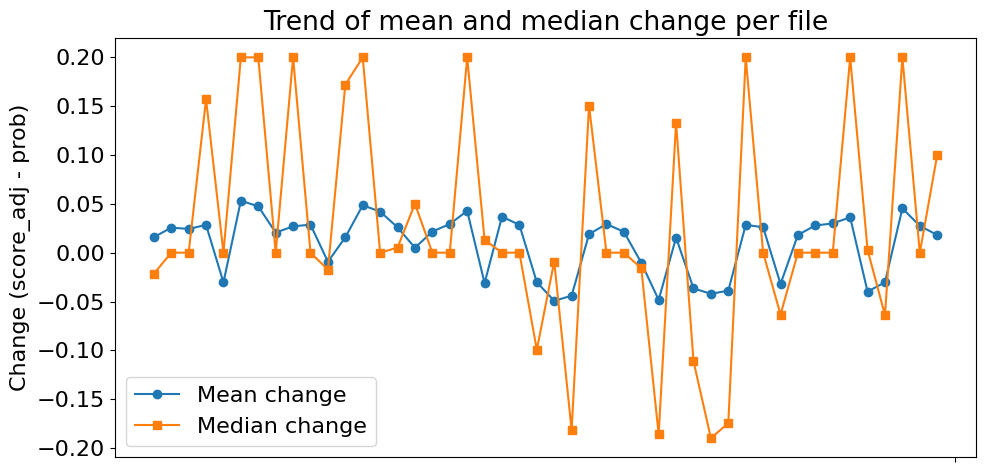

/scratch/temp/17103121/ipykernel_550726/3544589102.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


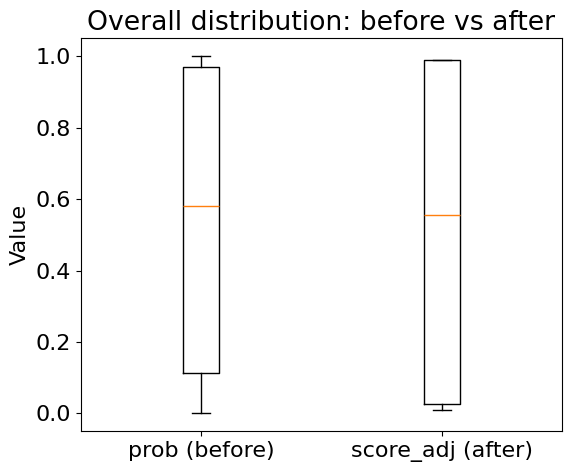

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure delta exists
if "delta" not in combined_df.columns:
    combined_df["delta"] = combined_df["score_adj"] - combined_df["prob"]

# --- 1) Trend plot of mean and median change per file ---
summary = (
    combined_df
    .groupby("source_file")
    .agg(
        mean_prob=("prob", "mean"),
        mean_score=("score_adj", "mean"),
        median_prob=("prob", "median"),
        median_score=("score_adj", "median"),
    )
)
summary["mean_change"] = summary["mean_score"] - summary["mean_prob"]
summary["median_change"] = summary["median_score"] - summary["median_prob"]

plt.figure(figsize=(10, 5))
plt.plot(summary.index, summary["mean_change"], marker="o", label="Mean change")
plt.plot(summary.index, summary["median_change"], marker="s", label="Median change")
plt.xticks("")
plt.ylabel("Change (score_adj - prob)")
plt.title("Trend of mean and median change per file")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) Overall boxplot: all before vs after (across all files) ---
plt.figure(figsize=(6, 5))
plt.boxplot(
    [combined_df["prob"].dropna().to_numpy(),
     combined_df["score_adj"].dropna().to_numpy()],
    labels=["prob (before)", "score_adj (after)"],
    showfliers=False
)
plt.ylabel("Value")
plt.title("Overall distribution: before vs after")
plt.tight_layout()
plt.show()



In [37]:
# Directory path
csv_dir = "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/PICA"

# Get all CSV files in the directory
csv_files = [
    f for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df['source_file'] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_control_df = pd.concat(dataframes, ignore_index=True)

combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...


In [38]:
import numpy as np

# Apply the function to the DataFrame
S, R = combined_score_sample_capped(
    P=combined_control_df["prob"].values,
    F_raw=combined_control_df["CloneFreq"].values,
    t_P=0.6,
    t_R=0.6,
    alpha=0.6,
    beta=0.8,
    delta_max=0.2,
    floor=0.01,
    ceil=0.99,
)

# Add results back to the DataFrame
combined_control_df["score_adj"] = S
combined_control_df["CloneFreq_percentile"] = R
combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file,score_adj,CloneFreq_percentile
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.575344,0.989394
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.982062
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.982062
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.982062
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.982062
...,...,...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.010000,0.522412
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.010000,0.522412
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.909164,0.522412
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.129552,0.522412


In [39]:
summary_control = (
    combined_control_df
    .groupby("source_file")
    .agg(
        mean_prob=("prob", "mean"),
        mean_score=("score_adj", "mean"),
        median_prob=("prob", "median"),
        median_score=("score_adj", "median"),
    )
)

# Add change columns
summary_control["mean_change"] = summary_control["mean_score"] - summary_control["mean_prob"]
summary_control["median_change"] = summary_control["median_score"] - summary_control["median_prob"]

print(summary_control)

                                                    mean_prob  mean_score  \
source_file                                                                 
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.462594    0.496970   
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.477089    0.513112   
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.462977    0.502100   
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.452303    0.491867   
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.457735    0.494615   
20240530_WGS_20240530_sc_PICA0001-PICA0007_PMID...   0.473976    0.509983   
20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool...   0.464074    0.404435   
20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool...   0.473532    0.427485   
20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool...   0.465907    0.411834   
20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool...   0.455955    0.490470   
20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool...   0.459861    0.495567   

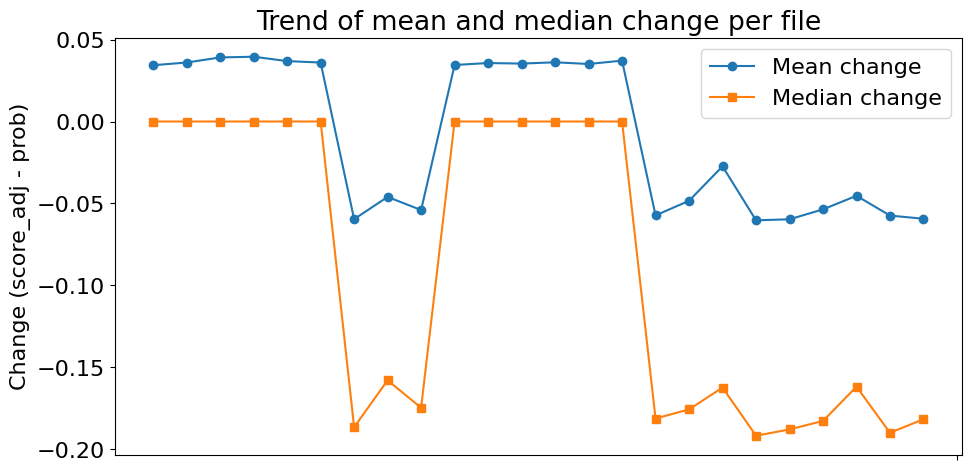

/scratch/temp/17103121/ipykernel_550726/1915526647.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


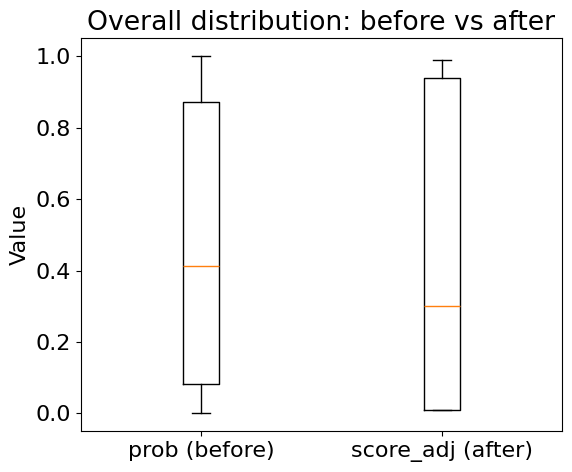

In [40]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(summary_control.index, summary_control["mean_change"], marker="o", label="Mean change")
plt.plot(summary_control.index, summary_control["median_change"], marker="s", label="Median change")
plt.xticks("")
plt.ylabel("Change (score_adj - prob)")
plt.title("Trend of mean and median change per file")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) Overall boxplot: all before vs after (across all files) ---
plt.figure(figsize=(6, 5))
plt.boxplot(
    [combined_control_df["prob"].dropna().to_numpy(),
     combined_control_df["score_adj"].dropna().to_numpy()],
    labels=["prob (before)", "score_adj (after)"],
    showfliers=False
)
plt.ylabel("Value")
plt.title("Overall distribution: before vs after")
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

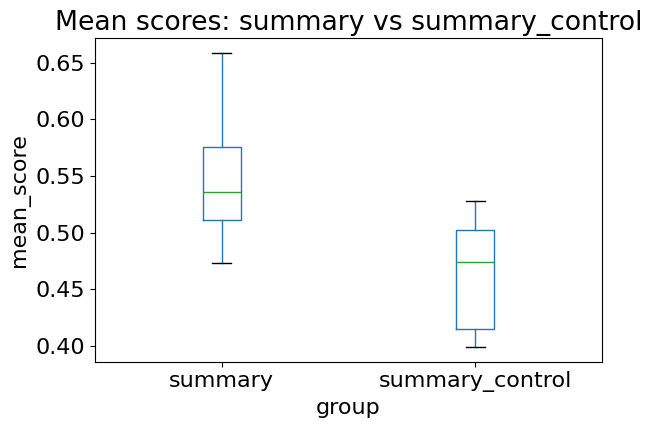

<Figure size 600x500 with 0 Axes>

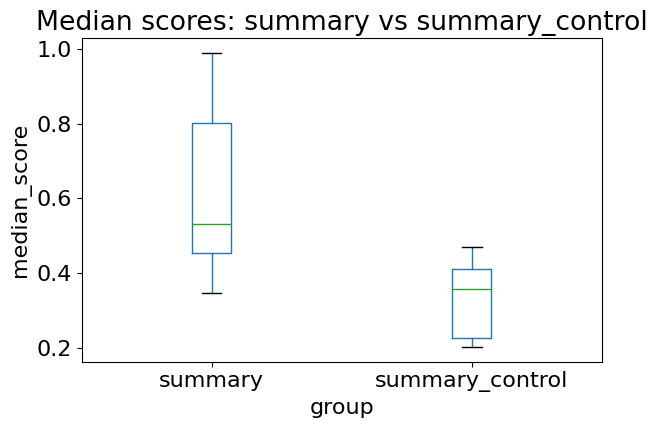

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Add a group label to each DataFrame
summary_labeled = summary.copy()
summary_labeled["group"] = "summary"

summary_control_labeled = summary_control.copy()
summary_control_labeled["group"] = "summary_control"

# Combine into one DataFrame
combined = pd.concat([summary_labeled, summary_control_labeled], ignore_index=True)

# --- Boxplot: mean_score comparison ---
plt.figure(figsize=(6, 5))
combined.boxplot(column="mean_score", by="group", showfliers=False)
plt.suptitle("")  # remove automatic title
plt.title("Mean scores: summary vs summary_control")
plt.ylabel("mean_score")
plt.grid(False)   # remove gridlines
plt.tight_layout()
plt.show()

# --- Boxplot: median_score comparison (if useful) ---
plt.figure(figsize=(6, 5))
combined.boxplot(column="median_score", by="group", showfliers=False)
plt.suptitle("")
plt.title("Median scores: summary vs summary_control")
plt.ylabel("median_score")
plt.grid(False)
plt.tight_layout()
plt.show()


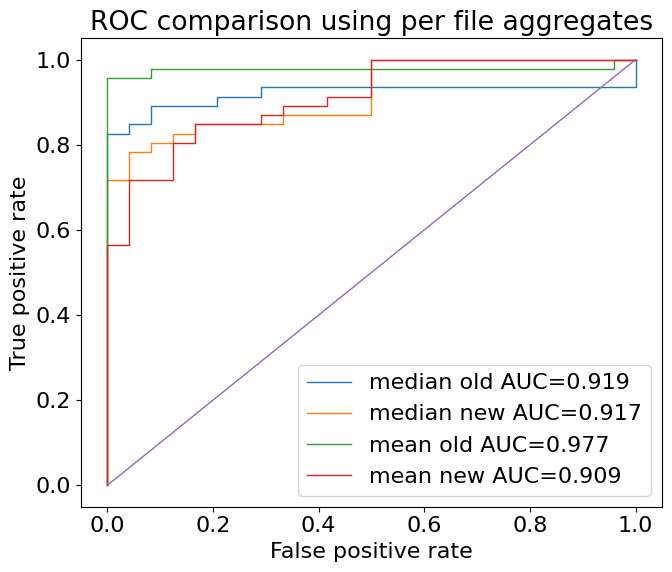

median old: AUC = 0.9194
median new: AUC = 0.9167
mean old: AUC = 0.9774
mean new: AUC = 0.9094


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already have two per file DataFrames:
#   summary with columns: mean_prob, mean_score, median_prob, median_score
#   summary_control with same columns
# If your column names differ, adjust the mapping in `metrics` below.

# Label and combine
summary_labeled = summary.copy()
summary_labeled["group_label"] = 1  # summary

summary_control_labeled = summary_control.copy()
summary_control_labeled["group_label"] = 0  # control

comb = pd.concat([summary_labeled, summary_control_labeled], ignore_index=True)

# Try sklearn first, else manual
def roc_curve_and_auc(y_true, scores):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, scores)
    return fpr, tpr, auc(fpr, tpr)
    

metrics = {
    "median old": "median_prob",
    "median new": "median_score",
    "mean old":   "mean_prob",
    "mean new":   "mean_score",
}

# Plot ROC
plt.figure(figsize=(7, 6))
aucs = {}
for label, col in metrics.items():
    if col not in comb.columns:
        print(f"Warning: column {col} not found, skipping {label}")
        continue
    fpr, tpr, a = roc_curve_and_auc(comb["group_label"], comb[col])
    aucs[label] = a
    plt.plot(fpr, tpr, linewidth=1, label=f"{label} AUC={a:.3f}" if a == a else f"{label} AUC=nan")

# Reference diagonal
plt.plot([0, 1], [0, 1], linewidth=1)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC comparison using per file aggregates")
plt.legend()
plt.tight_layout()
plt.show()

# Print AUCs
for k, v in aucs.items():
    print(f"{k}: AUC = {v:.4f}" if v == v else f"{k}: AUC = nan")
